# Bank Customer Churn — Exploration & XGBoost Model

This notebook uses raw data from kaggle to train an XGBoost classifier, plus export steps for a Power BI dashboard.

**How to use:**
1. Put `Churn_Modelling.csv` into the `/data/` folder (download from Kaggle) OR follow the Kaggle API instructions below.
2. Run cells sequentially.
3. Results will be created as .csv files for Power BI.

----

## Download dataset (two options)

**Option A — manual:** Go to the Kaggle dataset page and download `Churn_Modelling.csv` into the `data/` folder.

**Option B — Kaggle API (run locally where you have kaggle CLI configured):**

```bash
kaggle datasets download -d radheshyamkollipara/bank-customer-churn
unzip bank-customer-churn.zip -d data/
```

Make sure the CSV path ends up as `/data/Churn_Modelling.csv`.


# Prepare the Data for use

In [43]:
### Environment setup
# Run this cell once to install any missing packages (uncomment the pip line if needed).

# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

#import all libraries
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier

# Create folders if they don't exist
Path('data').mkdir(exist_ok=True)
Path('notebooks').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)
Path('dashboard').mkdir(exist_ok=True)

print('Folders ready: data/, notebooks/, models/, dashboard/')

Folders ready: data/, notebooks/, models/, dashboard/


In [44]:
### Load dataset


DATA_PATH = '/data/Churn_Modelling.csv'

if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please download and place it there.")

df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)
df.head()

Rows, cols: (10000, 18)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## Quick EDA

Inspect columns, types, nulls, basic churn rate.

In [45]:
df.info()

# Nulls
print('\nNull values per column:\n', df.isnull().sum())

# Basic churn rate
print('\nChurn (Exited) distribution:\n', df['Exited'].value_counts(normalize=True).map('{:.2%}'.format))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

### Visual Exploratory Data Analysis (EDA)

This next cell will generate some plots that will allow us to get a better understanding of the data.

We'll want to know what types of distributions we're working with across the whole data set to better understand our options for training the model and what fields are most useful.



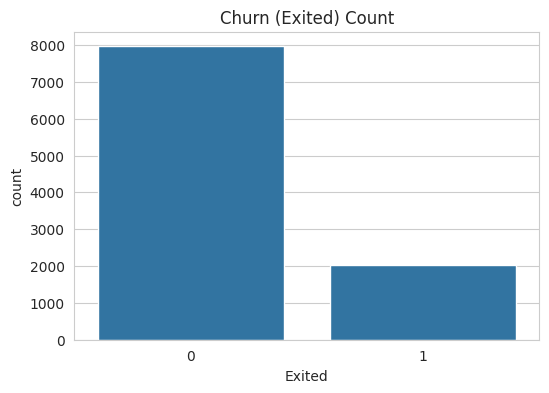

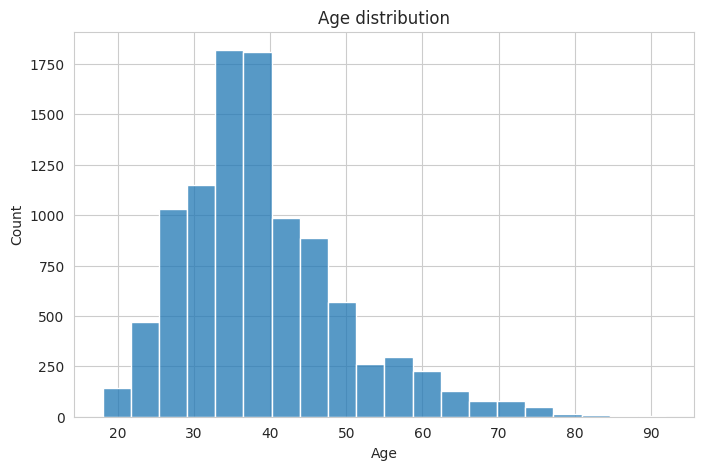

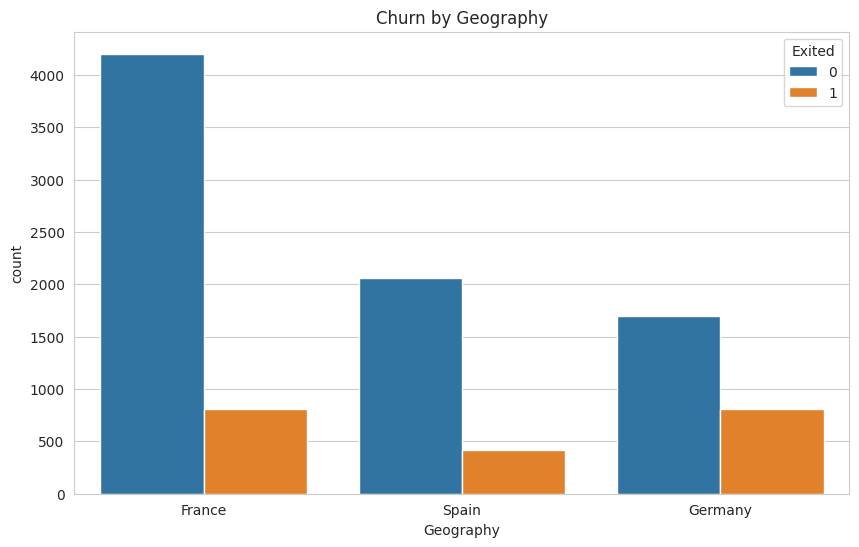

In [46]:
sns.set_style('whitegrid')

plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df)
plt.title('Churn (Exited) Count')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=20)
plt.title('Age distribution')
plt.show()

plt.figure(figsize=(10,6))
cat_cols = ['Geography','Gender']
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn by Geography')
plt.show()

## Preprocessing & Feature Engineering
- Drop identifier columns to prevent the model from "memorizing" the entry during training.
  - Otherwise, the model wouldn't be "predicting" but instead "remembering" the target variable's value.
- Encode categorical variables
  - To allow the model to extract valuable information from a nonnumeric format
- Split the data set into training and testing sets.

In [47]:
# Drop irrelevant ID columns
df_model = df.copy()
for col in ['RowNumber','CustomerId','Surname']:
    if col in df_model.columns:
        df_model.drop(columns=col, inplace=True)

# Define features and target
TARGET = 'Exited'
X = df_model.drop(TARGET, axis=1)
y = df_model[TARGET]

# Identify categorical and numeric
cat_features = [c for c in X.columns if X[c].dtype == 'object']
num_features = [c for c in X.columns if c not in cat_features]

cat_features, num_features[:10]

# Build preprocessing pipeline
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print('Train/Test sizes:', X_train.shape, X_test.shape)

Train/Test sizes: (8000, 14) (2000, 14)


## Train XGBoost classifier
Create a sklearn Pipeline that includes the preprocessor and XGBClassifier.

In [48]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=42)

model_pipeline = make_pipeline(preprocessor, xgb)

# Fit model
model_pipeline.fit(X_train, y_train)
print('Model trained')

Model trained


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:40:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Evaluation
Evaluate on the test set with classification report, confusion matrix, Receiver Operating Characteristic Area Under the Curve (ROC AUC), and feature importance (approximate for OneHotEncoder (OHE) features).

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion matrix:
 [[1591    1]
 [   2  406]]
ROC AUC: 0.9969424327519955


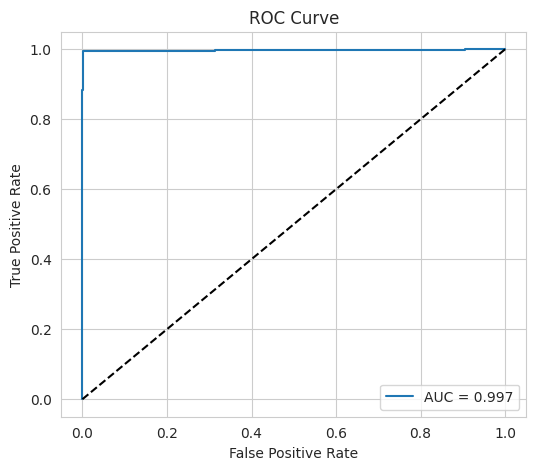

In [49]:
# Predict
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The precision and recall are too close to perfect to resemble a real world use case for the model. We'll want to find the feature that might be causing such strong predictions.

In [50]:
# Approximate feature importance: map OHE feature names back if possible

# Get feature names after preprocessing
ohe = model_pipeline.named_steps['columntransformer'].named_transformers_['ohe']
try:
    ohe_feature_names = list(ohe.get_feature_names_out(cat_features))
except Exception:
    # older sklearn fallback
    ohe_feature_names = []

feature_names = ohe_feature_names + num_features

try:
    booster = model_pipeline.named_steps['xgbclassifier'].get_booster()
    importances = booster.get_score(importance_type='gain')
    # Convert to DataFrame for display
    imp_df = pd.DataFrame([{'feature':k, 'importance':v} for k,v in importances.items()])
    imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
    display(imp_df.head(20))
except Exception as e:
    print('Could not extract raw booster importances:', e)

try:
    fi = model_pipeline.named_steps['xgbclassifier'].feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False)
    display(fi_df.head(20))
except Exception as e:
    print('Could not compute sklearn feature importances:', e)

,feature,importance
0,f17,301.344208
1,f6,1.574384
2,f13,1.124142
3,f10,0.704980
4,f15,0.696173
5,f9,0.622895
6,f1,0.613103
7,f11,0.592084
8,f5,0.578255
9,f18,0.556993


,feature,importance
17,Complain,0.969992
6,Card Type_GOLD,0.005068
13,NumOfProducts,0.003618
10,Age,0.002269
15,IsActiveMember,0.002241
9,CreditScore,0.002005
1,Geography_Germany,0.001974
11,Tenure,0.001906
5,Card Type_DIAMOND,0.001861
18,Satisfaction Score,0.001793


# Leakage Issue Spotted

The Complain feature is an almost perfect predictor of a customer exiting the bank. This means the feature might contain some unseen leakage. Leakage is when data from outside the training data is inadvertently used in model building. We'll want to remove this field to have a more real-world worthy model.

In [51]:
# SETTINGS
TARGET = 'Exited'
DROP_COLS = ['Complain', 'RowNumber', 'CustomerId', 'Surname']
MODEL_PATH = 'models/xgb_churn_pipeline.joblib'
EXPORT_PATH = 'dashboard/churn_predictions.csv'

# Prepare training data
df_model = df.copy()

# Drop unwanted columns (if present)
df_model.drop(columns=[c for c in DROP_COLS if c in df_model.columns], inplace=True)

X = df_model.drop(TARGET, axis=1)
y = df_model[TARGET]

# Identify categorical and numeric features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

#Data Integrity Check

We'll want to make sure that the columns we dropped don't exist prior to training

In [52]:
print("\n=== Data Integrity Check ===")
print(f"Dropped columns (should not appear): {DROP_COLS}")
print(f"Columns used for training: {list(X.columns)}")
print(f"Columns used for prediction: {list(X_all.columns)}")

missing_in_train = [c for c in DROP_COLS if c in X.columns]
missing_in_pred = [c for c in DROP_COLS if c in X_all.columns]

if not missing_in_train and not missing_in_pred:
    print("Integrity Check Passed: No leaked columns in training or prediction.")
else:
    print("Integrity Check Failed:")
    if missing_in_train:
        print(f"  - Still in training set: {missing_in_train}")
    if missing_in_pred:
        print(f"  - Still in prediction set: {missing_in_pred}")


=== Data Integrity Check ===
Dropped columns (should not appear): ['Complain', 'RowNumber', 'CustomerId', 'Surname']
Columns used for training: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score', 'Card Type', 'Point Earned']
Columns used for prediction: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score', 'Card Type', 'Point Earned']
Integrity Check Passed: No leaked columns in training or prediction.


In [53]:
# Split before training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train only on training data
model_pipeline.fit(X_train, y_train)

# Evaluate on held-out test set
y_pred = model_pipeline.predict(X_test)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.75      0.50      0.60       408

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.86      0.85      2000

Confusion matrix:
 [[1526   66]
 [ 206  202]]
ROC AUC: 0.8701888732880085


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.75      0.50      0.60       408

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.86      0.85      2000

Confusion matrix:
 [[1526   66]
 [ 206  202]]
ROC AUC: 0.8701888732880085


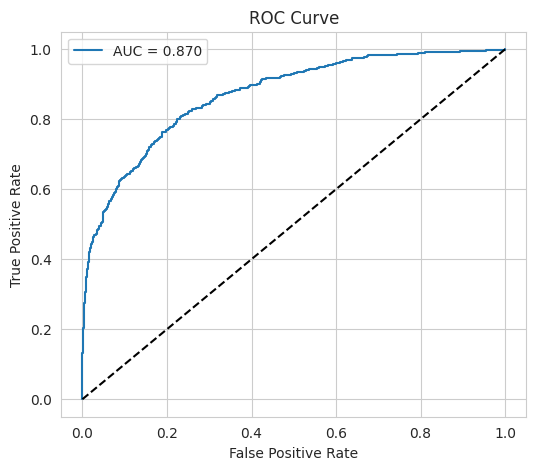

In [54]:
# Predict
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#Post-Training Analysis: Age & Salary Ranges

Now that we have accuracy ratings that are more in line with expectations, we can move forward with visualizing the results of our model. To help with our visualizations, we'll want to create ranges for Age and Salary since they have a large number of values that would not be helpful to keep separate.

To create these ranges, we'll separate the values into even quartiles and then translate those into ranges by taking the highest and lowest values.

We'll then plot those to verify they're helpful in our analysis.

Churn Rate by Age Range:
AgeRange
17–32    0.076344
32–37    0.108402
37–44    0.206763
44–92    0.446154
Name: Exited, dtype: float64

Churn Rate by Salary Range:
SalaryRange
$11–$51,002          0.2000
$51,002–$100,193     0.1980
$100,193–$149,388    0.2012
$149,388–$199,992    0.2160
Name: Exited, dtype: float64


/tmp/ipython-input-2271062903.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby('AgeRange')['Exited'].mean().sort_index())
/tmp/ipython-input-2271062903.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby('SalaryRange')['Exited'].mean().sort_index())
/tmp/ipython-input-2271062903.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_analysis.groupby('AgeRange')['E

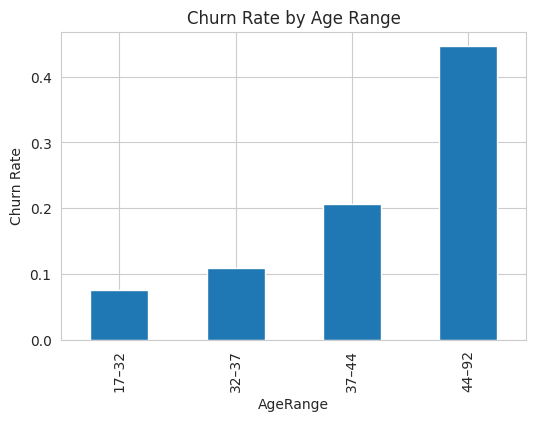

/tmp/ipython-input-2271062903.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_analysis.groupby('SalaryRange')['Exited'].mean().sort_index().plot(


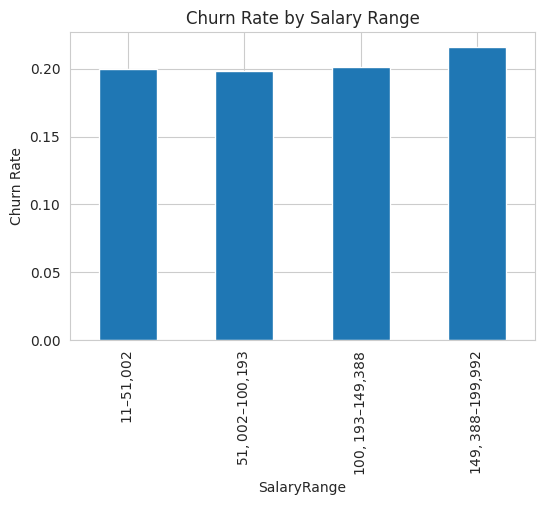

In [55]:
# Make a copy for safe analysis
df_analysis = df.copy()

# Age quartile ranges (labels like "21–32")
age_bins = pd.qcut(df_analysis['Age'], q=4)
df_analysis['AgeRange'] = age_bins.apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Salary quartile ranges (labels like "$20,000–$50,000")
salary_bins = pd.qcut(df_analysis['EstimatedSalary'], q=4)
df_analysis['SalaryRange'] = salary_bins.apply(lambda x: f"${int(x.left):,}–${int(x.right):,}")

# Churn rate by Age Range
print("Churn Rate by Age Range:")
print(df_analysis.groupby('AgeRange')['Exited'].mean().sort_index())

# Churn rate by Salary Range
print("\nChurn Rate by Salary Range:")
print(df_analysis.groupby('SalaryRange')['Exited'].mean().sort_index())

# Age Range plot
df_analysis.groupby('AgeRange')['Exited'].mean().sort_index().plot(
    kind='bar', figsize=(6,4), title="Churn Rate by Age Range", ylabel="Churn Rate"
)
plt.show()

# Salary Range plot
df_analysis.groupby('SalaryRange')['Exited'].mean().sort_index().plot(
    kind='bar', figsize=(6,4), title="Churn Rate by Salary Range", ylabel="Churn Rate"
)
plt.show()


## Save model & export predictions for Power BI
- Save the pipeline with joblib
- Export a CSV with the results of the training set
- Export a CSV with the results on the full set with original rows plus predicted probability and predicted label, and the salary and age ranges.

In [56]:
# Train/test split export
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model_pipeline.fit(X_train, y_train)

# Test evaluation
test_probs = model_pipeline.predict_proba(X_test)[:, 1]
test_preds = model_pipeline.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds))
print("ROC AUC:", roc_auc_score(y_test, test_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

# Save test set predictions (for validation in Power BI or external review)
test_export = X_test.copy()
test_export[TARGET] = y_test
test_export['pred_prob_churn'] = test_probs
test_export['pred_churn'] = test_preds
test_export.to_csv("dashboard/test_set_predictions.csv", index=False)

# Full dataset export
# Copy training data for full export
export_df = df_model.copy()

# Add predictions on full dataset
probs = model_pipeline.predict_proba(X)[:, 1]
preds = model_pipeline.predict(X)

export_df['pred_prob_churn'] = probs
export_df['pred_churn'] = preds

# Add readable Age & Salary ranges + sort order
age_bins = pd.qcut(export_df['Age'], q=4)
export_df['AgeRange'] = age_bins.apply(lambda x: f"{int(x.left)}–{int(x.right)}")
export_df['AgeRangeOrder'] = age_bins.cat.codes

salary_bins = pd.qcut(export_df['EstimatedSalary'], q=4)
export_df['SalaryRange'] = salary_bins.apply(lambda x: f"${int(x.left):,}–${int(x.right):,}")
export_df['SalaryRangeOrder'] = salary_bins.cat.codes

# Merge CustomerId back from original df
if 'CustomerId' in df.columns:
    export_df = export_df.merge(
        df[['RowNumber','CustomerId']],
        left_index=True,
        right_index=True,
        how='left'
    )

# Save full dataset predictions for Power BI
EXPORT_PATH = 'dashboard/churn_predictions.csv'
export_df.to_csv(EXPORT_PATH, index=False, encoding='utf-8-sig')
print("Exported predictions with ranges + sort order columns to", EXPORT_PATH)

# Show head
display(export_df.head())

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:40:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.75      0.50      0.60       408

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.86      0.85      2000

ROC AUC: 0.8701888732880085
Confusion Matrix:
 [[1526   66]
 [ 206  202]]
Exported predictions with ranges + sort order columns to dashboard/churn_predictions.csv


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Card Type,Point Earned,pred_prob_churn,pred_churn,AgeRange,AgeRangeOrder,SalaryRange,SalaryRangeOrder,RowNumber,CustomerId
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,DIAMOND,464,0.315516,0,37–44,2,"$100,193–$149,388",2,1,15634602
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,DIAMOND,456,0.274292,0,37–44,2,"$100,193–$149,388",2,2,15647311
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,DIAMOND,377,0.987422,1,37–44,2,"$100,193–$149,388",2,3,15619304
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,GOLD,350,0.063798,0,37–44,2,"$51,002–$100,193",1,4,15701354
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,GOLD,425,0.034753,0,37–44,2,"$51,002–$100,193",1,5,15737888


# Next Steps



1.   Take the two .csv files found in /content/dashboard (churn_predictions.csv and test_set_predictions.csv) and place them in PowerBI so they can each take up their own page in the report.
2.   The PowerBI file supplied will have premade measures and visualizations but any additional ones can be added to compare the data.


